# Pipelines en scikit-learn: de lo básico a lo avanzado

En este notebook aprenderemos a usar `Pipeline` y `ColumnTransformer` para construir flujos completos de ML:

1. **Pipeline simple**  
   - División train/test  
   - Escalado + modelo en una sola estructura

2. **Pipeline con validación y búsqueda de hiperparámetros**  
   - `cross_val_score`  
   - `GridSearchCV` con parámetros del pipeline

3. **Pipeline para datos mixtos (numéricos + categóricos)**  
   - `ColumnTransformer`  
   - `OneHotEncoder` para variables categóricas  
   - Escalado solo de columnas numéricas  

4. **Pipeline avanzado**  
   - Imputación de datos faltantes  
   - Escalado + One-Hot  
   - Selección de características  
   - Modelo final (Random Forest)  
   - Optimización de hiperparámetros del pipeline

El objetivo es que quede claro cómo encadenar todos los pasos de preprocesamiento y modelado de forma robusta y reproducible.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 5)
np.random.seed(42)


- Carga de datasets, el mismo que hemos venido trabajando. Además, hacemos la división

In [3]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

X.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape


((455, 30), (114, 30))

## 1. Pipeline básico: StandardScaler + LogisticRegression

La idea es empaquetar:

1. Escalado de features (`StandardScaler`)
2. Entrenamiento de un modelo lineal (`LogisticRegression`)

en un solo objeto `Pipeline`.


              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



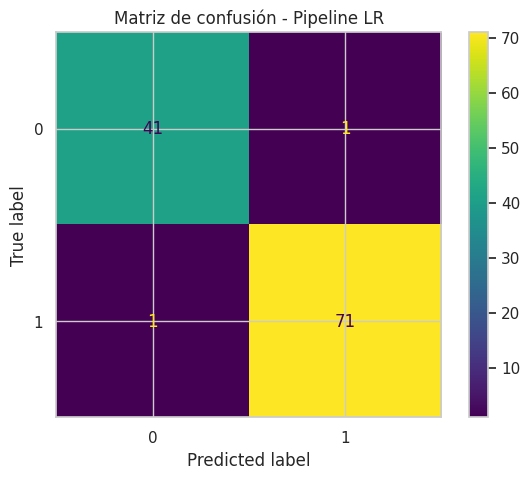

In [5]:
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=3000))
])

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)

print(classification_report(y_test, y_pred, target_names=data.target_names))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de confusión - Pipeline LR")
plt.show()


## 2. Pipeline con validación cruzada

Podemos usar `cross_val_score` directamente sobre el pipeline, sin preocuparnos del orden de los pasos.


In [6]:
scores = cross_val_score(pipe_lr, X_train, y_train, cv=5, scoring="accuracy")
print("Accuracy CV (LogisticRegression):", scores.mean(), "+/-", scores.std())


Accuracy CV (LogisticRegression): 0.9802197802197803 +/- 0.012815278889769896


## 3. GridSearchCV sobre un Pipeline

Ahora usamos un pipeline con `StandardScaler + SVC` y exploramos hiperparámetros.  
Importante: los nombres de los parámetros en la grilla se escriben como:

`<nombre_del_paso>__<nombre_parametro>`

Por ejemplo: `model__C`, `model__gamma`.


Mejores parámetros: {'model__C': 10, 'model__gamma': 0.01, 'model__kernel': 'rbf'}
Mejor accuracy (CV): 0.9802197802197803
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



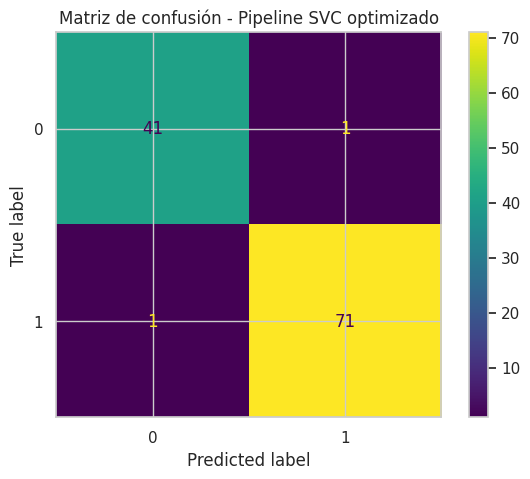

In [7]:
pipe_svc = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(probability=True))
])

param_grid = {
    "model__C": [0.1, 1, 10],
    "model__gamma": ["scale", 0.01, 0.001],
    "model__kernel": ["rbf"]
}

grid = GridSearchCV(
    pipe_svc,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor accuracy (CV):", grid.best_score_)

best_pipe = grid.best_estimator_
y_pred = best_pipe.predict(X_test)

print(classification_report(y_test, y_pred, target_names=data.target_names))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de confusión - Pipeline SVC optimizado")
plt.show()


- Pipelines con datos mixtos (numéricos + categóricos)

- Crearemos un dataset sintético

In [8]:
df = pd.DataFrame({
    "age": np.random.randint(18, 70, size=200),
    "income": np.random.normal(30000, 10000, size=200).round(0),
    "gender": np.random.choice(["male", "female"], size=200),
    "city": np.random.choice(["Santiago", "Punta Arenas", "Valdivia"], size=200),
    "purchased": np.random.choice([0, 1], size=200, p=[0.6, 0.4])
})

df.head()


,age,income,gender,city,purchased
0,69,3448.0,male,Santiago,1
1,46,33455.0,female,Punta Arenas,1
2,32,26045.0,female,Punta Arenas,0
3,60,27109.0,male,Valdivia,1
4,25,34529.0,male,Valdivia,1


In [9]:
X = df.drop(columns=["purchased"])
y = df["purchased"]

numeric_features = ["age", "income"]
categorical_features = ["gender", "city"]


## 4. Pipeline para datos mixtos: ColumnTransformer

Para tratar columnas numéricas y categóricas de forma distinta:

- Numéricas:
  - Imputación (si hay NaNs)
  - Escalado (`StandardScaler`)

- Categóricas:
  - Imputación (si hay NaNs)
  - One-Hot Encoding (`OneHotEncoder`)


              precision    recall  f1-score   support

           0       0.64      0.72      0.68        25
           1       0.42      0.33      0.37        15

    accuracy                           0.57        40
   macro avg       0.53      0.53      0.52        40
weighted avg       0.56      0.57      0.56        40



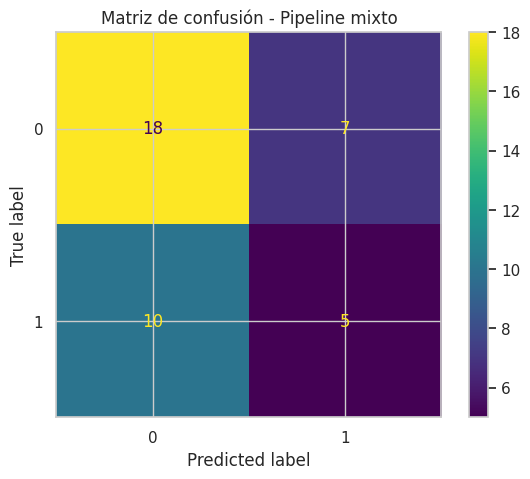

In [10]:
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de confusión - Pipeline mixto")
plt.show()


### Pipeline avanzado: imputación + selección de variables + modelo + grid search

Ahora armamos algo más “pro” usando el dataset de cáncer de mama, pero metiendo:

- imputación (por si hubiera NaNs),
- escalado,
- selección de características,
- modelo,
- GridSearchCV de hiperparámetros del pipeline.

In [11]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


## 5. Pipeline avanzado con múltiples pasos

Pasos del pipeline:

1. `imputer`: imputar valores faltantes (por si aparecen en datos reales).
2. `scaler`: `StandardScaler`.
3. `selector`: `SelectKBest` con ANOVA F-test para clasificación.
4. `model`: `RandomForestClassifier`.

Luego haremos `GridSearchCV` variando:
- número de features seleccionadas
- número de árboles
- profundidad máxima del RF


In [12]:
pipe_advanced = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(score_func=f_classif)),
    ("model", RandomForestClassifier(random_state=42))
])

param_grid = {
    "selector__k": [5, 10, 15, "all"],
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 5, 10]
}

grid_adv = GridSearchCV(
    pipe_advanced,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_adv.fit(X_train, y_train)

print("Mejores parámetros:", grid_adv.best_params_)
print("Mejor accuracy (CV):", grid_adv.best_score_)


Mejores parámetros: {'model__max_depth': None, 'model__n_estimators': 300, 'selector__k': 'all'}
Mejor accuracy (CV): 0.9582417582417584


              precision    recall  f1-score   support

   malignant       0.93      0.93      0.93        42
      benign       0.96      0.96      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



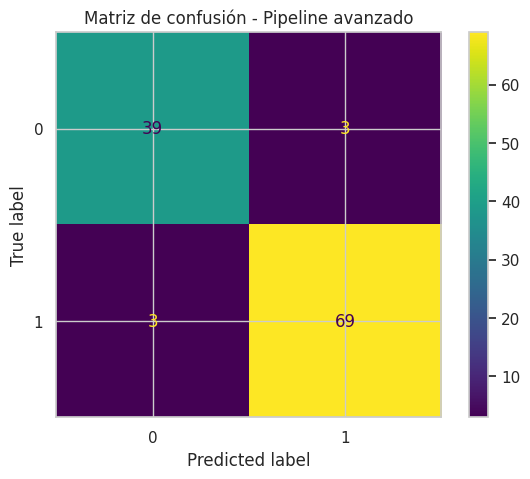

In [13]:
best_pipe_adv = grid_adv.best_estimator_

y_pred = best_pipe_adv.predict(X_test)

print(classification_report(y_test, y_pred, target_names=data.target_names))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matriz de confusión - Pipeline avanzado")
plt.show()


- Uso del pipeline

In [14]:
# Tomamos una muestra del test como "nuevo dato"
nuevo = X_test.iloc[[0]]

print("Nuevo dato (features):")
print(nuevo)

pred = best_pipe_adv.predict(nuevo)
proba = best_pipe_adv.predict_proba(nuevo)

print("\nPredicción (clase):", pred, "=>", data.target_names[pred][0])
print("Probabilidades (maligno, benigno):", proba)


Nuevo dato (features):
     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
256        19.55         28.77           133.6     1207.0           0.0926   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
256            0.2063          0.1784               0.1144         0.1893   

     mean fractal dimension  ...  worst radius  worst texture  \
256                 0.06232  ...         25.05          36.27   

     worst perimeter  worst area  worst smoothness  worst compactness  \
256            178.6      1926.0            0.1281             0.5329   

     worst concavity  worst concave points  worst symmetry  \
256           0.4251                0.1941          0.2818   

     worst fractal dimension  
256                   0.1005  

[1 rows x 30 columns]

Predicción (clase): [0] => malignant
Probabilidades (maligno, benigno): [[1. 0.]]
